In [83]:
%load_ext autoreload
%autoreload 2

%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import os
import shutil
import subprocess
from subprocess import CalledProcessError

import json

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook, tqdm

import nibabel
from nipype.interfaces.dcm2nii import Dcm2niix

from utils.process_rtog_nii import process_rtog_nii
from utils.mri_viewer import MRIViewer

In [85]:
indexed_images_fields = pd.read_csv("rtog_kept_dicoms_T1post_flair.csv").set_index(["patient_id", "modality"])
indexed_images_fields

Unnamed: 0  columns        date  \
patient_id     modality                                    
125^126^825^^  t1post           119      236  20040318.0   
               flair            118      512  20040318.0   
6^2421^825^^   t1post           196      416  20090622.0   
               flair            197      448  20090622.0   
20^3722^825^^  t1post           173      512  20090625.0   
               flair            175      256  20090625.0   
16^7758^825^^  t1post           159      512  20090630.0   
               flair            158      512  20090630.0   
25^7504^825^^  t1post         28545      256  20090704.0   
               flair          28548      512  20090704.0   
27^5715^825^^  flair            305      512  20090710.0   
               t1post           303      512  20090710.0   
21^3722^825^^  flair            256      192  20090724.0   
               t1post           257      192  20090724.0   
46^2508^825^^  flair            428      512  20090801.0   
               t1post           426      512  20090801.0   
48^2503^825^^  flair            452      512  20090811.0   
               t1post           450      512  20090811.0   
52^8907^825^^  t1post           466      256  20090811.0   
               flair            471      528  20090811.0   
79^154^825^^   t1post           603      560  20090812.0   
               flair            606      512  20090812.0   
56^2424^825^^  t1post           506      488  20090816.0   
               flair            509      488  20090816.0   
75^9682^825^^  t1post           595      448  20090821.0   
               flair            593      384  20090821.0   
55^1324^825^^  flair            498      512  20090824.0   
               t1post           495      512  20090824.0   
53^2408^825^^  t1post           477      400  20090825.0   
               flair            476      336  20090825.0   
...                             ...      ...         ...   
809^7751^825^^ t1post         19473      256  20110427.0   
977^2226^825^^ t1post         20355      512  20110427.0   
809^7751^825^^ flair          19540      256  20110427.0   
977^2226^825^^ flair          20351      256  20110427.0   
959^147^825^^  t1post         20120      512  20110429.0   
               flair          20114      256  20110429.0   
720^2411^825^^ t1post         20828      448  20110517.0   
               flair          20826      448  20110517.0   
925^5901^825^^ flair          21076      256  20110517.0   
               t1post         21078      256  20110517.0   
914^8201^825^^ flair          22066      440  20110630.0   
               t1post         22068      448  20110630.0   
815^1523^825^^ flair          22536      384  20110718.0   
               t1post         22498      256  20110718.0   
804^4101^825^^ t1post         22515      270  20110720.0   
               flair          22519      348  20110720.0   
979^8005^825^^ t1post         22785      512  20110727.0   
               flair          22787      512  20110727.0   
890^9682^825^^ t1post         26073      192  20120116.0   
               flair          26072      192  20120116.0   
474^2421^825^^ flair          26279      320  20120210.0   
               t1post         26280      256  20120210.0   
635^607^825^^  flair          26543      256  20120308.0   
               t1post         26539      256  20120308.0   
387^7819^825^^ t1post         26501      256  20120315.0   
               flair          26499      256  20120315.0   
722^7504^825^^ flair          27649      560  20121002.0   
               t1post         27647      512  20121002.0   
318^2444^825^^ t1post         27933      256  20130306.0   
               flair          27932      256  20130306.0   

                                              description  \
patient_id     modality                                     
125^126^825^^  t1post                   AXIAL T1 POST_FIL   
               flair                          AXIAL FLAIR   


In [86]:
list_paths = []
for patient in indexed_images_fields.index.get_level_values(0).unique():
    patient_id = patient.split("^")[0]
    patient_df = indexed_images_fields.loc[patient]
    t1post_path = patient_df.loc["t1post"].raw_path
    t1flair_path = patient_df.loc["flair"].raw_path
    list_paths.append((t1post_path, t1flair_path, patient_id))

## Convert and move to scratch images

In [123]:
def compose_dcm2niix_command(input_path, output_path):
    assert os.path.isdir(input_path)
    assert os.path.isdir(output_path)
    command = "dcm2niix -b y -z y -x n -t n -m n -o {} -s n -v n {}"
    return command.format(output_path, input_path.replace(" ", "\ ")\
                                                  .replace("&", "\&")\
                                                  .replace("(", "\(")\
                                                 .replace(")", "\)")\
                                                 .replace("'", "\\'"))

def dcm2niix(input_path, output_path, verbose=False):
    command = compose_dcm2niix_command(input_path, output_path)
    if verbose:
        print("[]$ ", command)
        print(subprocess.check_output(command, shell=True).decode("utf-8"))
    else:
        subprocess.check_output(command, shell=True).decode("utf-8")

In [124]:
def empty_directory(directory_path):
    assert os.path.isdir(directory_path)
    if len(os.listdir(directory_path)) > 0:
        for content in os.listdir(directory_path):
            abs_content_path = os.path.join(directory_path, content)
            if os.path.isdir(abs_content_path):
                shutil.rmtree(abs_content_path)
            else:
                os.remove(abs_content_path)
    assert len(os.listdir(directory_path)) ==0

In [125]:
def convert_and_copy_dcm_foler(dcm_path, patientID, modality, scratch_path="/local-scratch/marcthib_scratch/rtog/",
                              verbose=False):
    assert modality in ['t1c', 'flair']
    
    scratch_tmp_path = os.path.join(scratch_path, 'tmp')
    if not os.path.isdir(scratch_tmp_path):
        os.mkdir(scratch_tmp_path)
    empty_directory(scratch_tmp_path)
    
    output_path = os.path.join(scratch_path, str(patientID) + modality + ".nii.gz")

    try: 
        dcm2niix(dcm_path, scratch_tmp_path, verbose=verbose)
    except CalledProcessError as e:
        if e.returncode == -11:
            return
            print("SegFault, did not convert image", patientID, modality, dcm_path)
        if e.returncode == 2:
            print("Not an image, did not convert image", patientID, modality, dcm_path)
        else:
            raise e
    
    list_created_files = os.listdir(scratch_tmp_path)
    json_created = [t for t in list_created_files if ".json" in t]
    
    for json_path in json_created:
        with open(os.path.join(scratch_tmp_path, json_path)) as f:
            ImageType = json.load(f)["ImageType"]
        if 'ORIGINAL' in ImageType:
            nii_gz_path = json_path.strip(".json") + ".nii.gz"
            shutil.move(os.path.join(scratch_tmp_path, nii_gz_path), 
                        output_path)
            if verbose:
                print("Outputed nii.gz file to ", output_path)
            subprocess.call(["gunzip", output_path])
            if verbose:
                print("Decompressed nii file to ", output_path.strip(".gz"))
            break
    empty_directory(scratch_tmp_path)

In [126]:
for t1post_path, t1flair_path, patient_id in tqdm_notebook(list_paths):
    convert_and_copy_dcm_foler(t1post_path, patient_id, "t1c")
    convert_and_copy_dcm_foler(t1flair_path, patient_id, "flair")


Not an image, did not convert image 394 t1c /labs/gevaertlab/users/hackhack/RTOG/RTOG_duplicate/0825-6686 DAR/2010-04__Studies/394^7819^825_394_MR_2010-04-28_132409_MR.BRAIN.LAB.FULL.PRFS.W.WO_Axial.T1.post.thin_n60__00000
Not an image, did not convert image 394 flair /labs/gevaertlab/users/hackhack/RTOG/RTOG_duplicate/0825-6686 DAR/2010-04__Studies/394^7819^825_394_MR_2010-04-28_132409_MR.BRAIN.LAB.FULL.PRFS.W.WO_Axial.FLAIR_n30__00001
Not an image, did not convert image 477 t1c /labs/gevaertlab/users/hackhack/RTOG/RTOG_duplicate/0825-6686 DAR/2010-06__Studies/477^5915^825_477_MR_2010-06-15_082931_MR.BRAIN.W.ADDITIONAL.VIEWS_Ax.T1.SE.Post_n30__00000
Not an image, did not convert image 580 t1c /labs/gevaertlab/users/hackhack/RTOG/RTOG_duplicate/0825-6686 DAR/2010-09__Studies/580^5702^825_580_MR_2010-09-10_160659_MRI.BRAIN.WWO.CONTRAST_Axial.T1.Post_n28__00000
Not an image, did not convert image 580 flair /labs/gevaertlab/users/hackhack/RTOG/RTOG_duplicate/0825-6686 DAR/2010-09__Studie

# Compare before and after pre-processing

In [138]:
patient_number = 338
scratch_folder = "/local-scratch/marcthib_scratch/rtog"

In [139]:
viewer_args = []

for image_definition in ['t1c', 'flair', 't1c', 'flair']:
    image_path = os.path.join(scratch_folder, str(patient_number) + image_definition + '.nii')
    nibabel_item = nibabel.load(image_path)
    image_data = nibabel_item.get_data()
    image_data[np.isnan(image_data)] = 0.
    viewer_args.append(np.swapaxes(image_data, 0, 2))

viewer_args.append(None)
for image_definition in ['t1c', 'flair', 't1c', 'flair']:
    viewer_args.append(image_definition)

<IPython.core.display.Javascript object>


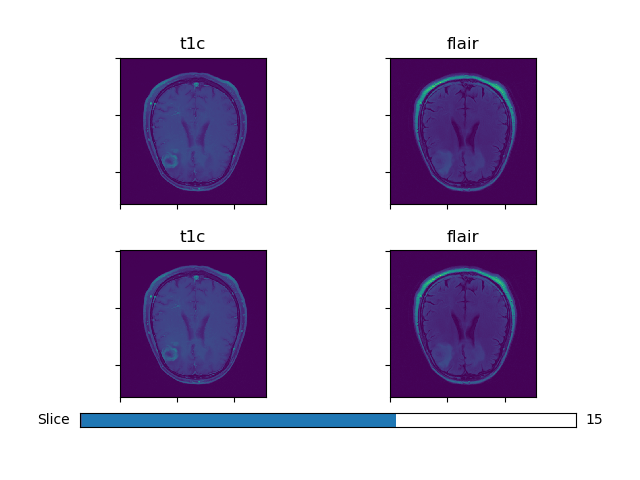

In [140]:
MRIViewer(*viewer_args)